# DCGAN

- Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks(https://arxiv.org/pdf/1511.06434.pdf)

![alt text](./dcgan.png)

## 1. Import required libraries

In [1]:
# Vanilla GAN with Multi GPUs + Naming Layers using OrderedDict
# Code by GunhoChoi

import torch
import torch.nn as nn
import torch.utils as utils
import torch.nn.init as init
import torchvision.utils as v_utils
import torchvision.datasets as dset
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict

import os
 

os.environ["CUDA_VISIBLE_DEVICES"]="0"


## 2. Hyperparameter setting

In [2]:
# Set Hyperparameters
# change num_gpu to the number of gpus you want to use

epoch = 50
batch_size = 512
learning_rate = 0.0002
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## 3. Data Setting

In [3]:
# Download Data

mnist_train = dset.MNIST("./", train=True, 
                         transform=transforms.Compose([
                             transforms.ToTensor(),
                             transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                        ]),
                        target_transform=None,
                        download=True)

# Set Data Loader(input pipeline)

train_loader = torch.utils.data.DataLoader(dataset=mnist_train,batch_size=batch_size,shuffle=True,drop_last=True)

## 4. Generator

In [4]:
# Generator receives random noise z and create 1x28x28 image
# we can name each layer using OrderedDict

class Generator(nn.Module):
    def __init__(self):
        super(Generator,self).__init__()
        self.layer1 = nn.Sequential(
             nn.Linear(100,7*7*256),
             nn.BatchNorm1d(7*7*256),
             nn.ReLU(),
        )
        self.layer2 = nn.Sequential(OrderedDict([
                        ('conv1', nn.ConvTranspose2d(256,128,3,2,1,1)),
                        ('bn1', nn.BatchNorm2d(128)),
                        ('relu1', nn.LeakyReLU()),
                        ('conv2', nn.ConvTranspose2d(128,64,3,1,1)),
                        ('bn2', nn.BatchNorm2d(64)),    
                        ('relu2', nn.LeakyReLU()),
            ]))
        self.layer3 = nn.Sequential(OrderedDict([
                        ('conv3',nn.ConvTranspose2d(64,16,3,1,1)),
                        ('bn3',nn.BatchNorm2d(16)),    
                        ('relu3',nn.LeakyReLU()),
                        ('conv4',nn.ConvTranspose2d(16,1,3,2,1,1)),
                        ('relu4',nn.Tanh())
            ]))

    def forward(self,z):
        out = self.layer1(z)
        out = out.view(batch_size,256,7,7)
        out = self.layer2(out)
        out = self.layer3(out)
        return out

## 5. Discriminator

In [5]:
# Discriminator receives 1x28x28 image and returns a float number 0~1
# we can name each layer using OrderedDict

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator,self).__init__()
        self.layer1 = nn.Sequential(OrderedDict([
                        ('conv1',nn.Conv2d(1,8,3,padding=1)),   # batch x 16 x 28 x 28
                        ('bn1',nn.BatchNorm2d(8)),    
                        ('relu1',nn.LeakyReLU()),
                        ('conv2',nn.Conv2d(8,16,3,padding=1)),  # batch x 32 x 28 x 28
                        ('bn2',nn.BatchNorm2d(16)),    
                        ('relu2',nn.LeakyReLU()),
                        ('max1',nn.MaxPool2d(2,2))   # batch x 32 x 14 x 14
        ]))
        self.layer2 = nn.Sequential(OrderedDict([
                        ('conv3',nn.Conv2d(16,32,3,padding=1)),  # batch x 64 x 14 x 14
                        ('bn3',nn.BatchNorm2d(32)),
                        ('relu3',nn.LeakyReLU()),
                        ('max2',nn.MaxPool2d(2,2)),
                        ('conv4',nn.Conv2d(32,64,3,padding=1)),  # batch x 128 x 7 x 7
                        ('bn4',nn.BatchNorm2d(64)),
                        ('relu4',nn.LeakyReLU())
        ]))
        self.fc = nn.Sequential(
                        nn.Linear(64*7*7,1),
                        nn.Sigmoid()
        )

    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(batch_size, -1)
        out = self.fc(out)
        return out

## 6. Put instances on Multi-gpu

In [6]:
# Put class objects on Multiple GPUs using 
# torch.nn.DataParallel(module, device_ids=None, output_device=None, dim=0)
# device_ids: default all devices / output_device: default device 0 
# along with .cuda()

generator = nn.DataParallel(Generator()).to(device)
discriminator = nn.DataParallel(Discriminator()).to(device)

## 8. Set Loss function & Optimizer

In [7]:
# loss function, optimizers, and labels for training

loss_func = nn.MSELoss()
gen_optim = torch.optim.Adam(generator.parameters(), lr= 5*learning_rate,betas=(0.5,0.999))
dis_optim = torch.optim.Adam(discriminator.parameters(), lr=learning_rate,betas=(0.5,0.999))

ones_label = torch.ones(batch_size,1).to(device)
zeros_label = torch.zeros(batch_size,1).to(device)

def image_check(gen_fake):
    img = gen_fake.data.numpy()
    for i in range(10):
        plt.imshow(img[i][0],cmap='gray')
        plt.show()

## 10. Train Model

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:10: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:21: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.


tensor(0.2110, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.6654, device='cuda:0', grad_fn=<ThAddBackward>)
0th iteration gen_loss: 0.2110057771205902 dis_loss: 0.665444016456604
tensor(0.3243, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.4593, device='cuda:0', grad_fn=<ThAddBackward>)
0th iteration gen_loss: 0.3243279755115509 dis_loss: 0.4593128561973572
tensor(0.3428, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.4462, device='cuda:0', grad_fn=<ThAddBackward>)
0th iteration gen_loss: 0.34278568625450134 dis_loss: 0.44624245166778564


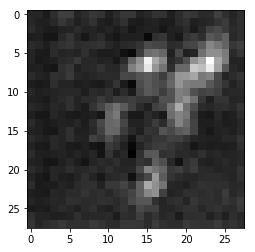

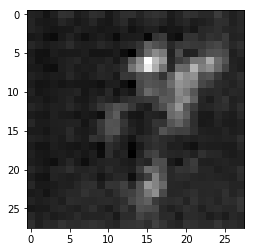

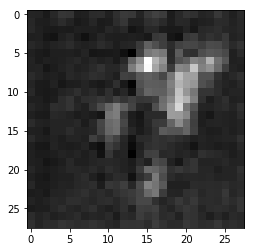

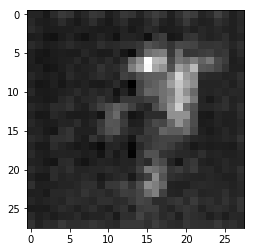

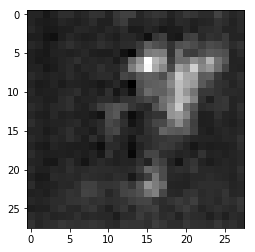

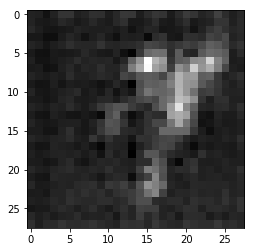

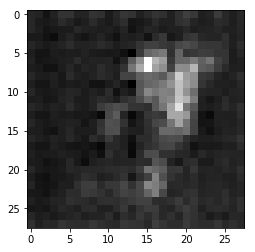

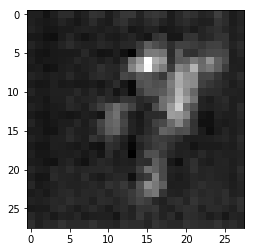

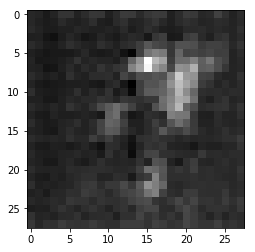

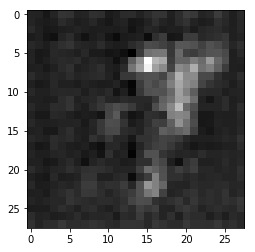

tensor(0.3072, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.4562, device='cuda:0', grad_fn=<ThAddBackward>)
1th iteration gen_loss: 0.3071880340576172 dis_loss: 0.4561954140663147
tensor(0.2991, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.4680, device='cuda:0', grad_fn=<ThAddBackward>)
1th iteration gen_loss: 0.2991480231285095 dis_loss: 0.4679907560348511
tensor(0.4260, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.3030, device='cuda:0', grad_fn=<ThAddBackward>)
1th iteration gen_loss: 0.42598602175712585 dis_loss: 0.3029990792274475


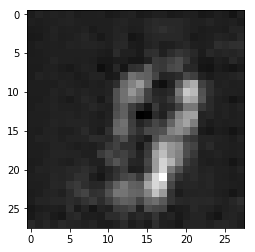

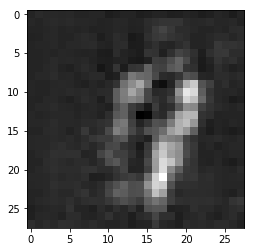

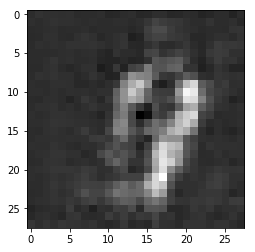

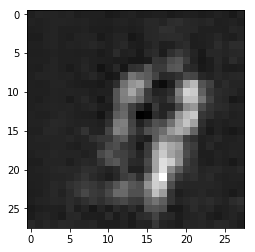

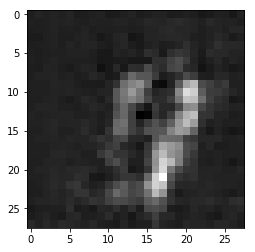

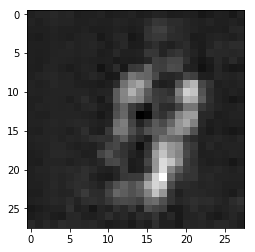

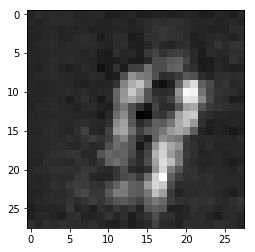

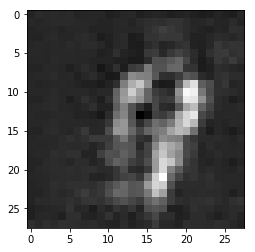

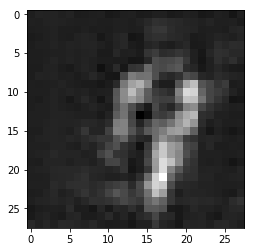

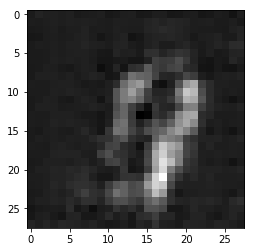

tensor(0.4188, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.3798, device='cuda:0', grad_fn=<ThAddBackward>)
2th iteration gen_loss: 0.4188495874404907 dis_loss: 0.3797807991504669
tensor(0.4634, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.3007, device='cuda:0', grad_fn=<ThAddBackward>)
2th iteration gen_loss: 0.4633753299713135 dis_loss: 0.30068397521972656
tensor(0.4573, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.3659, device='cuda:0', grad_fn=<ThAddBackward>)
2th iteration gen_loss: 0.45727378129959106 dis_loss: 0.3659185767173767


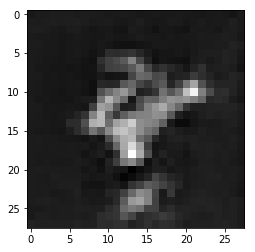

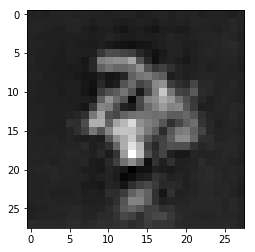

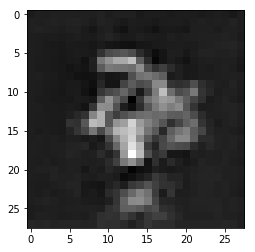

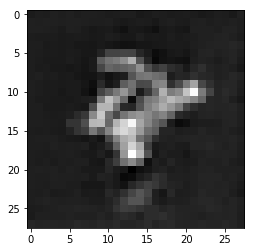

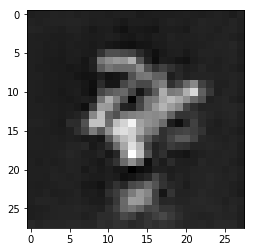

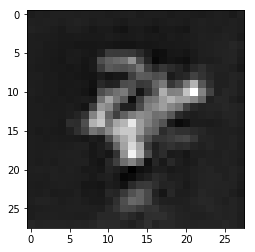

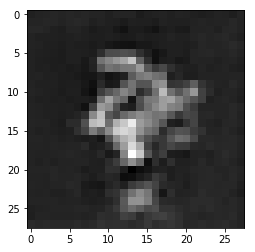

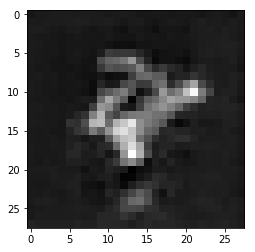

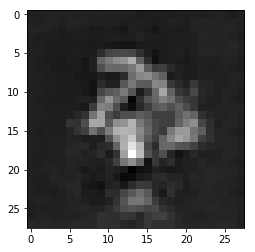

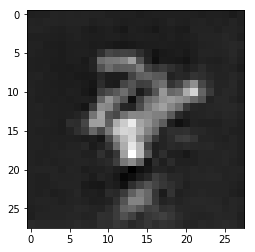

tensor(0.5069, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.2408, device='cuda:0', grad_fn=<ThAddBackward>)
3th iteration gen_loss: 0.5068768262863159 dis_loss: 0.2408370077610016
tensor(0.4473, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.2869, device='cuda:0', grad_fn=<ThAddBackward>)
3th iteration gen_loss: 0.4473271667957306 dis_loss: 0.2868937849998474
tensor(0.5153, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.2524, device='cuda:0', grad_fn=<ThAddBackward>)
3th iteration gen_loss: 0.5152658820152283 dis_loss: 0.2523648142814636


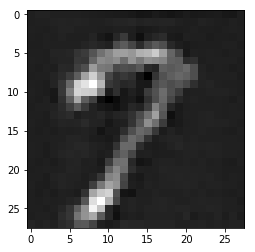

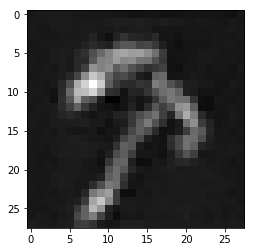

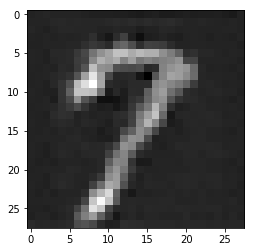

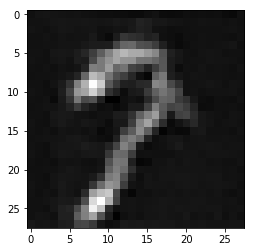

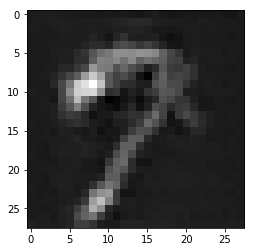

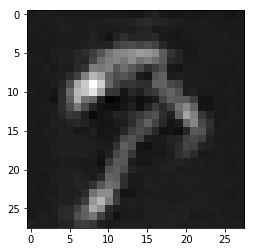

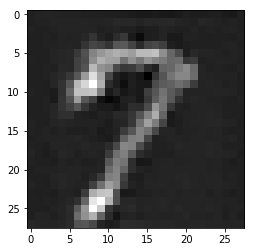

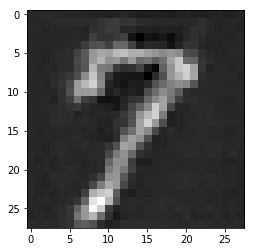

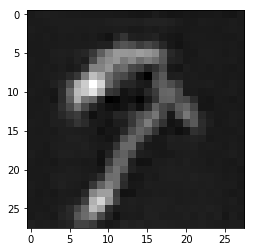

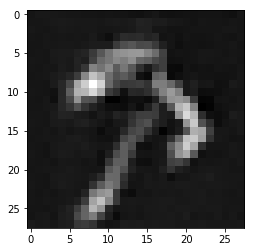

tensor(0.5448, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.2817, device='cuda:0', grad_fn=<ThAddBackward>)
4th iteration gen_loss: 0.5448463559150696 dis_loss: 0.28173214197158813
tensor(0.5048, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.3141, device='cuda:0', grad_fn=<ThAddBackward>)
4th iteration gen_loss: 0.5047616362571716 dis_loss: 0.3141479790210724
tensor(0.5741, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.1791, device='cuda:0', grad_fn=<ThAddBackward>)
4th iteration gen_loss: 0.5741111636161804 dis_loss: 0.17914040386676788


In [ ]:
# train

for i in range(epoch):
    for j,(image,label) in enumerate(train_loader):
        image = image.to(device)
        
        # generator
        gen_optim.zero_grad()
        
        z = init.normal(torch.Tensor(batch_size,100),mean=0,std=0.1).to(device)
        gen_fake = generator.forward(z)
        dis_fake = discriminator.forward(gen_fake)
        
        gen_loss = torch.sum(loss_func(dis_fake,ones_label)) # fake classified as real
        gen_loss.backward()
        gen_optim.step()
    
        # discriminator
        dis_optim.zero_grad()
        
        z = init.normal(torch.Tensor(batch_size,100),mean=0,std=0.1).to(device)
        gen_fake = generator.forward(z)
        dis_fake = discriminator.forward(gen_fake)
        
        dis_real = discriminator.forward(image)
        dis_loss = torch.sum(loss_func(dis_fake,zeros_label)) + torch.sum(loss_func(dis_real,ones_label))
        dis_loss.backward()
        dis_optim.step()
    
        # model save
        if j % 50 == 0:
            print(gen_loss,dis_loss)

            print("{}th iteration gen_loss: {} dis_loss: {}".format(i,gen_loss.data,dis_loss.data))
            v_utils.save_image(gen_fake.data[0:25],"gen_{}_{}.png".format(i,j), nrow=5)
            
    image_check(gen_fake.cpu())